# Introduction

**The purpose of this notebook is to develop a classification model to predict whether a customer would deposit savings into the subjected bank. For model training, full data set is deployed, with approximately 41.4k rows and 21 columns. Then, the trained model will be prepared for cloud usage, which will be available at streamlit for public to use.**

- **Download [Data](https://archive.ics.uci.edu/dataset/222/bank+marketing)**

# Training Methodology
**Model development will be taken into consideration with two different approaches. First, due to the imbalanced nature of the target variable, the under-sampled target variable "yes" will be synthetically re-populated using SMOTE. Thereon, the main performance metric will be the accuracy score of prediction. Next, under-sampled target variable will not be re-populated, and thus, the main performance metric will be Precision - Recall Curve and scores.**

## Workflow

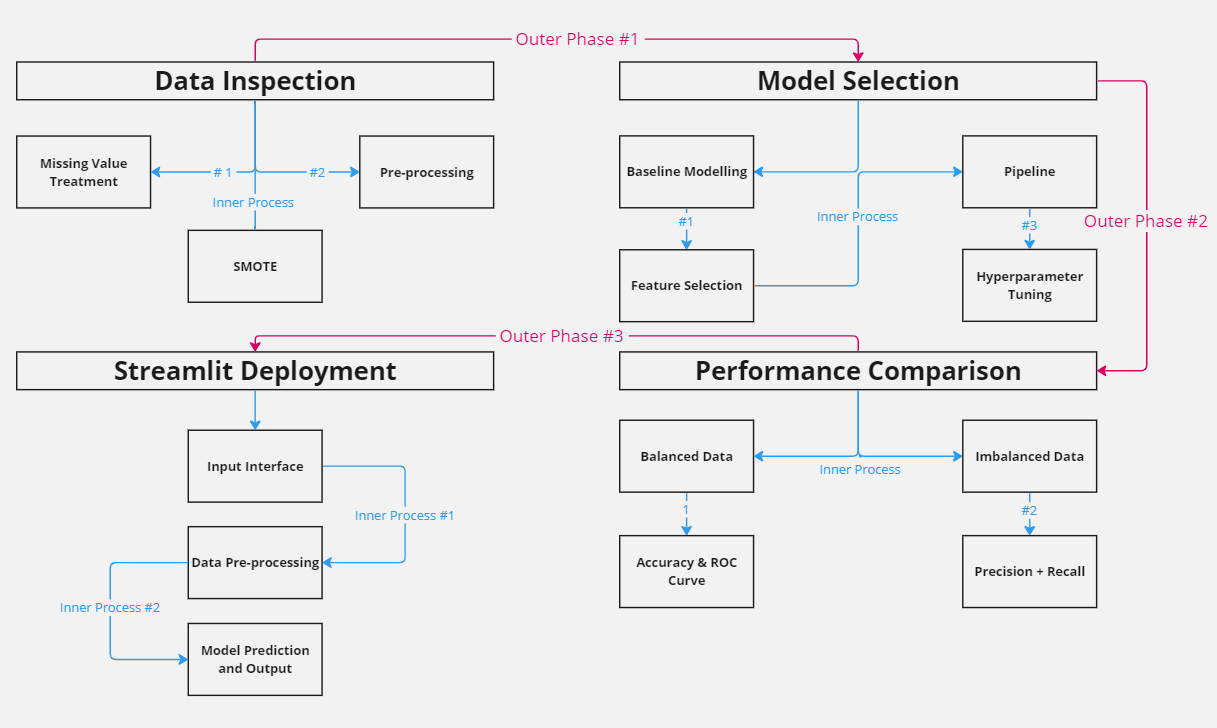

# Libraries


In [1]:
# Required Libraries
!pip install shap --quiet
!pip install xgboost --quiet
!pip install optuna --quiet
# Model
from xgboost import XGBClassifier
import xgboost as xgb
# Model Feature Selection
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
# Pipeline
from sklearn.pipeline import Pipeline
# Model Preprocessing
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
# Model Imputation
from sklearn.impute import KNNImputer
# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
# Model Metrics
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
# Optimization
import optuna
from optuna.visualization.matplotlib import plot_param_importances
# Basic Packages
import matplotlib.pyplot as plt
import joblib
from joblib import dump, load
import pandas as pd
from typing import Iterable
import numpy as np
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.6 MB/s eta 0:00:00


# Useful Functions

**Below find some useful functions that are deployed later on this notebook for various objectives.**



  - **inspect_data**: Generates an inspection dataframe containing information about the columns in a given DataFrame.
  - **pre_process**: Replaces unique values in categorical columns of a DataFrame with corresponding indices.


In [2]:
def inspect_data(data):

    """
    Generates an inspection dataframe containing information about the columns in a given DataFrame.

    Args:
        data (pandas.DataFrame): The DataFrame to inspect.

    Returns:
        pandas.DataFrame: The inspection dataframe containing column names, data types, missing values, and unknown variable counts.

    """
    col_name=[]
    col_dtype=[]
    mv_count=[]
    unkown_count=[]
    dtype_correction=[]

    # Converts "unknown" values into np.nan
    for cols in data.columns:
        data.loc[data[cols]=="unknown", cols] = np.nan

    # creates an inspection dataframe
    for cols in data.columns:
        col_name.append(cols.capitalize())
        col_dtype.append(data[cols].dtypes)
        mv_count.append(data[cols].isnull().sum())
        unkown_count.append(data[cols].value_counts().get("unknown", 0))

    # Dataframe above lists
    _ = pd.DataFrame({"Column":col_name,
                     "Data Type":col_dtype,
                     "Missing Values": mv_count,
                     "Unkown Variable":unkown_count})
    return _

def replace_categorical_with_indices(data)->list:
  """
  Replaces unique values in categorical columns of a DataFrame with corresponding indices.

  Args:
      dataframe (pandas.DataFrame): The DataFrame containing the categorical columns to be modified.

  Returns:
      pandas.DataFrame: The modified DataFrame with categorical values replaced by indices.

  """
  # Filter columns with "Object" datatype
  categorical_variables = data.select_dtypes("object")
  categorical_column_list = list(categorical_variables.columns)

  # Create a dictionary of keys and values for "Object" datatype columns
  categorical_column_dict = {}
  for cv in categorical_column_list:
      categorical_column_dict[cv] = categorical_variables[cv].unique()

  # Replace unique values with corresponding indices
  for column, values in categorical_column_dict.items():
      value_dict = {value: index for index, value in enumerate(values) if not pd.isnull(value)}
      categorical_variables[column] = categorical_variables[column].replace(value_dict)

  # masks categoric variables from numerical columns and replace them with processed version
  numerical_variables = data.loc[:, ~data.columns.isin(categorical_variables.columns)]
  data = pd.concat([numerical_variables, categorical_variables], axis=1)

  return data

# Data Description

|Variable Name|Variable Description|
|-|-|
| age|Numeric|
| job|  type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")|
| marital| marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)|
| education| (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")|
| default| has credit in default? (categorical: "no","yes","unknown")|
| housing|  has housing loan? (categorical: "no","yes","unknown")|
| loan| has personal loan? (categorical: "no","yes","unknown")|
| contact| contact communication type (categorical: "cellular","telephone")|
| month| last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")|
| day_of_week| last contact day of the week (categorical: "mon","tue","wed","thu","fri")|
| duration| last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.|
| campaign| number of contacts performed during this campaign and for this client (numeric, includes last contact)|
| pdays| number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)|
| previous|  number of contacts performed before this campaign and for this client (numeric)|
| poutcome| outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")|
| emp.var.rate| employment variation rate - quarterly indicator (numeric)|
| cons.price.idx| consumer price index - monthly indicator (numeric)|
| cons.conf.idx| consumer confidence index - monthly indicator (numeric)|
| euribor3m| euribor 3 month rate - daily indicator (numeric)|
| nr.employed| number of employees - quarterly indicator (numeric)|


In [3]:
train_df = pd.read_csv("/content/bank-additional-full[1].csv",
                       delimiter=";") # the csv is formatted using ";"

In [4]:
train_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Exploratory Data Analysis

In [5]:
inspect_data(train_df)

,Column,Data Type,Missing Values,Unkown Variable
0,Age,float64,0,0
1,Job,object,330,0
2,Marital,object,80,0
3,Education,object,1731,0
4,Default,object,8597,0
5,Housing,object,990,0
6,Loan,object,990,0
7,Contact,object,0,0
8,Month,object,0,0
9,Day_of_week,object,0,0


In [6]:
processed_train_df = replace_categorical_with_indices(train_df)
processed_train_df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,56.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
1,57.0,149.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,1.0,NaN,0.0,0.0,0,0,0,0,0
2,37.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,1.0,0.0,1.0,0.0,0,0,0,0,0
3,40.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,2.0,0.0,0.0,0.0,0,0,0,0,0
4,56.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,1.0,0.0,0.0,1.0,0,0,0,0,0


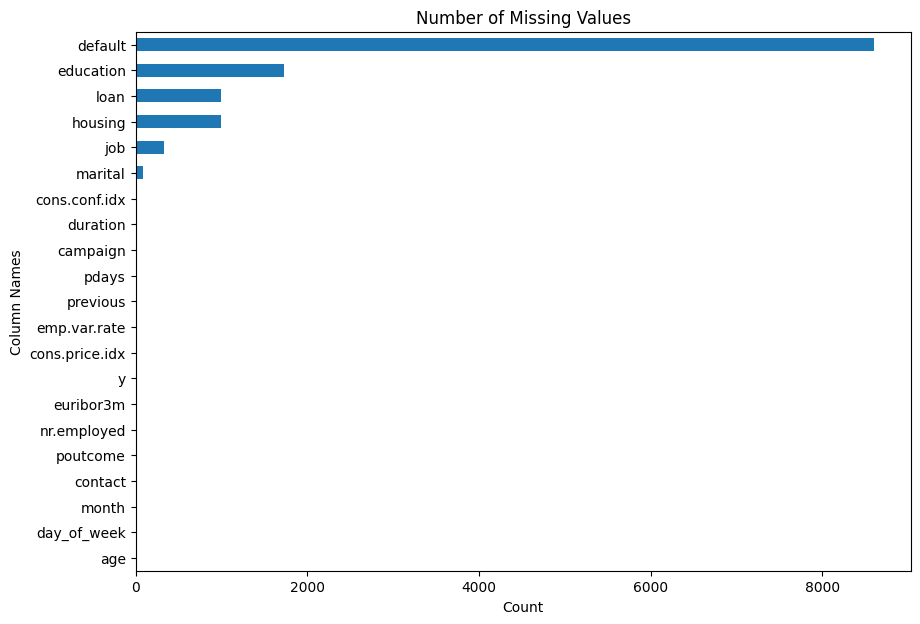

In [7]:
plt.figure(figsize=(10,7))
processed_train_df.isnull().sum().sort_values().plot(kind="barh", title="Number of Missing Values");
plt.xlabel("Count");
plt.ylabel("Column Names");

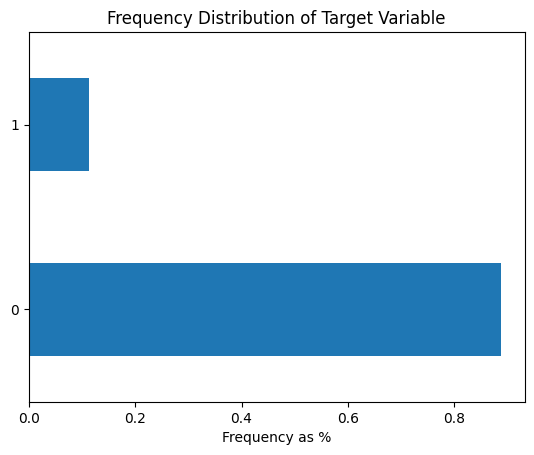

In [8]:
processed_train_df.y.value_counts(normalize=True).plot(kind="barh", title="Frequency Distribution of Target Variable");plt.xlabel("Frequency as %");

# Missing-Value Treatment
**In total, there are 12.7k missing values, ~ 30% of training data. Missing values will be treated using KNNImputer imputation method. This method applies k-nearest neighbor algorithm to calculate the distance between the provided features, and as a result, closes features are imputed and assigned accordingly the mean of the distance. The distance calculation is based on the euclidean formula**

- **[Sklearn KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)**

In [9]:
knn_imputer = KNNImputer(missing_values=np.nan,
                        weights="distance",
                        metric="nan_euclidean")
processed_train_df = knn_imputer.fit_transform(processed_train_df)
processed_train_df = pd.DataFrame(processed_train_df, columns=[train_df.columns])

In [10]:
# Controlling for missing values
for col in processed_train_df.columns:
    col_name = str(col).replace("('", "").replace("',)", "")
    if pd.isna(processed_train_df[col]).any():
        print("missing values detected in ", str(col_name) + " column")
    else:
        print("no missing values in", str(col_name) + " column")

no missing values in age column
no missing values in job column
no missing values in marital column
no missing values in education column
no missing values in default column
no missing values in housing column
no missing values in loan column
no missing values in contact column
no missing values in month column
no missing values in day_of_week column
no missing values in duration column
no missing values in campaign column
no missing values in pdays column
no missing values in previous column
no missing values in poutcome column
no missing values in emp.var.rate column
no missing values in cons.price.idx column
no missing values in cons.conf.idx column
no missing values in euribor3m column
no missing values in nr.employed column
no missing values in y column


# Balanced Data

### SMOTE Application
**Synthetic Minority Oversampling Technique (SMOTE) is a data augmentation method for tabular data. Under-sampled variables are duplicated more frequently and thus, are synthetically augmented for more representation.**

**Utilization:**

  - Sampling strategy is set as "not majority", thereon the majority class, or labels, will not be re-sampled. The re-sampling will be concluded as soon as the labels are balanced

**Resources**
  - https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
  - https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

In [11]:
X = processed_train_df.drop(["y"], axis=1)
y = processed_train_df["y"]

print(f"Feature Data Shape {X.shape}, \nTarget Data Shape {y.shape}")

Feature Data Shape (41188, 20), 
Target Data Shape (41188, 1)


In [12]:
# SMOTE Application
smote = SMOTE(sampling_strategy="not majority",
              random_state=42)
X, y = smote.fit_resample(X, y)
print(y.value_counts(normalize=True))

(y,)
0.0     0.5
1.0     0.5
dtype: float64


## Feature Selection

**Feature selection will be conducted using Recursive Feature Elimination (RFE). RFE allows the baseline model to assign importance for each feature deployed. Later, the weighted features are ranked in an accordance with their corresponding importance score. The least significant features, in terms of ranking, are pruned from the model.**

- **[Sklearn Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)**

In [13]:
# Model Fit
estimator = XGBClassifier()
feature_selector = RFECV(estimator=estimator,
                         step=1,
                         cv=5,
                         scoring="accuracy")
# Wrapper fit
feature_selector.fit(X, y)

RFECV(cv=5,
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...),
      scoring='accuracy')

### Feature Selection Diagnosis

In [14]:
# Cross-validation results
rfecv_output = feature_selector.cv_results_

cv_results={}
for key, values in rfecv_output.items():
  cv_results[key] = round(np.mean(values),2)

cv_results = pd.DataFrame.from_dict(cv_results,orient="index",
                                    columns=["Accuracy"])
cv_results

,Accuracy
mean_test_score,0.70
std_test_score,0.18
split0_test_score,0.60
split1_test_score,0.87
split2_test_score,0.94
split3_test_score,0.59
split4_test_score,0.51


In [15]:
# Mask columns with the highest importance
mask = feature_selector.get_support()
features = np.array(X.columns)
best_features = features[mask]

print("Selected best: ", best_features.shape[0])
print(features[mask])

Selected best:  6
[('job',) ('day_of_week',) ('campaign',) ('poutcome',) ('cons.price.idx',)
 ('euribor3m',)]


In [16]:
# Get ranking list
ranking_list = {}
column_names = list(X.columns)
column_names
importance_list = list(feature_selector.ranking_)
for feature, col in zip(importance_list, column_names):
    ranking_list[col] = feature

# Convert dict to pandas dataframe
ranking_list = pd.DataFrame.from_dict(ranking_list,
                                      orient="index",
                                      columns=["Ranking"]).sort_values(by="Ranking")
# importance ranking
best_ranking = ranking_list.loc[ranking_list["Ranking"]==1]
best_ranking.index = [str(col).replace("(", "").replace(")", "").replace(",", "").replace("'", "") for col in best_ranking.index]
best_ranking

,Ranking
day_of_week,1
job,1
cons.price.idx,1
poutcome,1
campaign,1
euribor3m,1


## Model Development

In [17]:
# Select and split train/validation data from the most important features
X_best = X[list(best_ranking.index.values)]
best_X_train, best_X_test, y_train, y_test = train_test_split(X_best, y,
                                                              test_size=0.25,
                                                              random_state=42)

In [18]:
print(f"best X_train shape: {best_X_train.shape} \ny_train shape: {y_train.shape} \nbest X_test shape: {best_X_test.shape} \ny_test shape:{y_test.shape}")

best X_train shape: (54822, 6) 
y_train shape: (54822, 1) 
best X_test shape: (18274, 6) 
y_test shape:(18274, 1)


### Pipeline

**The pipeline is consisted of MinMaxScaler and XGBClassifier. MinMaxScaler is applied in order to scale down outliers within the inter-quartile range. Thereon, the algorithm is further enabled to capture non-linear relationships more accurate.**

In [19]:
# Pipeline with Model and MinMaxScaler
pipeline = Pipeline([("MMS",MinMaxScaler()),
                     ("XGBM", XGBClassifier(random_state=42))])
# Hyperparameters
XGBM_parameters = [{"XGBM__learning_rate":[0.01, 0.05, 0.1],
                    "XGBM__n_estimators":[1000, 2000, 3000],
                    "XGBM__max_depth":[3, 5, 7],
                    "XGBM__subsample":[0.5, 0.6, 0.7],
                    "XGBM__gamma":[1,3,5],
                    "XGBM__colsample_bytree":[0.5, 0.6, 0.7],
                    "XGBM__reg_alpha":[0.1, 0.3, 0.5],
                    "XGBM__reg_lambda":[0.1, 0.3, 0.5],
                    "XGBM__min_child_weight":[0.1, 0.3, 0.5],
                    }]

### Hyperparameter Tuning
**RandomizedSearchCV package is the main hyperparameter tuning tool to be used for this work. Hyperparameters will be tuned with minuscle range and relatively larger intervals. Default values will remain as they are, and will not be pruned throughout the tuning processes.**

In [ ]:
# Cross-validation with Randomized Search Grid
xgbm_classifier = RandomizedSearchCV(estimator=pipeline,
                                     param_distributions=XGBM_parameters,
                                     scoring="accuracy",
                                     verbose=2,
                                     random_state=42)
# RandomizedSearchCV model fitting
xgbm_classifier.fit(best_X_train, y_train)
xgbm_preds=xgbm_classifier.predict(best_X_test)

In [21]:
# CV Accuracy and Best Parameter Selection
print("XGBClassifier Accuracy: {:.3f}".format(accuracy_score(y_test, xgbm_preds)),
      "\nBest Parameters: {}".format(xgbm_classifier.best_params_))

XGBClassifier Accuracy: 0.941 
Best Parameters: {'XGBM__subsample': 0.7, 'XGBM__reg_lambda': 0.3, 'XGBM__reg_alpha': 0.1, 'XGBM__n_estimators': 1000, 'XGBM__min_child_weight': 0.3, 'XGBM__max_depth': 7, 'XGBM__learning_rate': 0.05, 'XGBM__gamma': 1, 'XGBM__colsample_bytree': 0.7}


In [23]:
# re-fit the best model
best_cv_model = XGBClassifier(subsample=0.7, reg_lambda=0.3, n_estimators=1000,
                              min_child_weight=0.3, max_depth=7, learning_rate=0.05,
                              gamma=1, colsample_bytree=0.7
                            )
best_cv_model.fit(best_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=0.3, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [24]:
# save best model
dump(best_cv_model, filename="xgbclassifier.joblib")
# load model
best_model = joblib.load("/content/xgbclassifier.joblib")

## Model Performance


In [25]:
best_model.fit(best_X_train, y_train)
y_pred = best_model.predict(best_X_test)

In [26]:
y.value_counts(normalize=True)

(y,)
0.0     0.5
1.0     0.5
dtype: float64

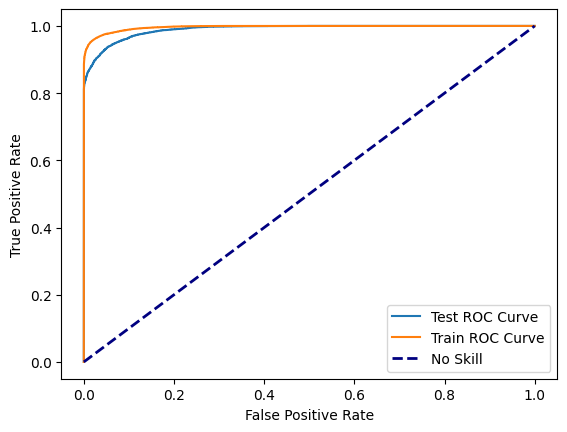

In [30]:
# test prediction probabilities
test_pred_proba = best_model.predict_proba(best_X_test)
test_pos_probs = test_pred_proba[:, 1]

# train prediction probabilities
train_pred_proba = best_model.predict_proba(best_X_train)
train_pos_probs = train_pred_proba[:, 1]

# test / train precision, recall, and thresholds
test_fpr, test_tpr, test_threshold = roc_curve(y_test, test_pos_probs)
train_fpr, train_tpr, train_threshold = roc_curve(y_train, train_pos_probs)

# Display ROC Curve
plt.plot(test_fpr, test_tpr,  label='Test ROC Curve')
plt.plot(train_fpr, train_tpr,  label='Train ROC Curve')
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="No Skill")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.show()

In [31]:
print(classification_report(y_test, y_pred, target_names=["No","Yes"]))

              precision    recall  f1-score   support

          No       0.93      0.95      0.94      9167
         Yes       0.95      0.93      0.94      9107

    accuracy                           0.94     18274
   macro avg       0.94      0.94      0.94     18274
weighted avg       0.94      0.94      0.94     18274



In [32]:
# RSCV-Optimized Model
accuracy_score(y_test, y_pred)

0.9414468643975047

# Imbalanced Data

## Model Development

In [ ]:
# Selected Features based on importance
imb_X = X[["job","marital","housing","loan","campaign","pdays",
            "poutcome","cons.price.idx","cons.conf.idx", "euribor3m",
            "nr.employed"]]

# Split train and validation
imb_X_train, imb_X_test, imb_y_train, imb_y_test = train_test_split(imb_X,y,test_size=0.25, random_state=42)

### Pipeline

In [ ]:
# Pipeline with Model and MinMaxScaler
imb_pipeline = Pipeline([("MMS",MinMaxScaler()),
                     ("XGBM", XGBClassifier(random_state=42))])
# Hyperparameters
XGBM_parameters_imb = [{"XGBM__learning_rate":[0.01, 0.1, 0.2],
                    "XGBM__n_estimators":[1000, 2000],
                    "XGBM__max_depth":[3, 5, 7],
                    "XGBM__subsample":[0.5, 0.6],
                    "XGBM__gamma":[1,3],
                    "XGBM__colsample_bytree":[0.5, 0.6],
                    "XGBM__reg_alpha":[0.1, 0.3],
                    "XGBM__reg_lambda":[0.1, 0.3],
                    "XGBM__min_child_weight":[0.1, 0.3],
                    }]

### Hyperparameter Tuning

In [ ]:
# Cross-validation with Randomized Search Grid
imb_xgbm_classifier = RandomizedSearchCV(estimator=imb_pipeline,
                                     param_distributions=XGBM_parameters_imb,
                                     scoring="accuracy",
                                     verbose=2,
                                     random_state=42)
# RandomizedSearchCV model fitting
imb_xgbm_classifier.fit(imb_X_train, imb_y_train)
imb_xgbm_preds=imb_xgbm_classifier.predict(imb_X_test)

In [ ]:
# Fit Model and Predict
imb_pred = imb_xgbm_classifier.predict(imb_X_test)
print("XGBClassifier Precision Score: {:.3f}".format(average_precision_score(imb_y_test, imb_pred)),
      "\nBest Parameters: {}".format(imb_xgbm_classifier.best_params_))

XGBClassifier Precision Score: 0.934 
Best Parameters: {'XGBM__subsample': 0.6, 'XGBM__reg_lambda': 0.3, 'XGBM__reg_alpha': 0.3, 'XGBM__n_estimators': 1000, 'XGBM__min_child_weight': 0.3, 'XGBM__max_depth': 7, 'XGBM__learning_rate': 0.01, 'XGBM__gamma': 1, 'XGBM__colsample_bytree': 0.5}


In [ ]:
imb_model = XGBClassifier(subsample=0.6, reg_lambda=0.3, reg_alpha=0.3,
                          n_estimators=1000, min_child_weight=0.3, max_depth=7,
                          learning_rate=0.01, gamma=1, colsample_bytree=0.5)
imb_model.fit(imb_X_train, imb_y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=0.3, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Model Performance

In [ ]:
# Label Distribution
y.value_counts(normalize=True)

(y,)
0.0     0.887346
1.0     0.112654
dtype: float64

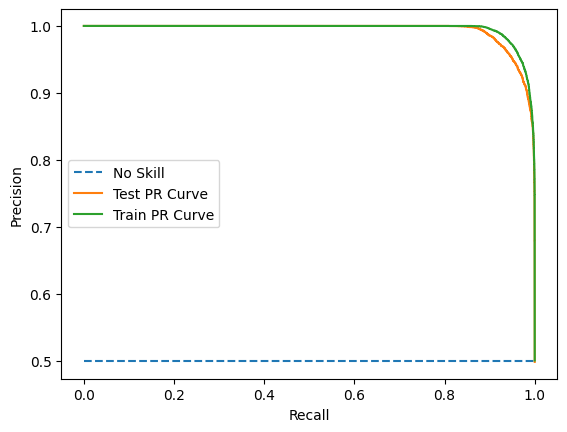

In [ ]:
# test prediction probabilities
test_pred_proba = imb_model.predict_proba(imb_X_test)
test_pos_probs = test_pred_proba[:, 1]

# train prediction probabilities
train_pred_proba = imb_model.predict_proba(imb_X_train)
train_pos_probs = train_pred_proba[:, 1]

# calculate the no skill line as the proportion of the positive class
no_skill = 0.5

# Precision-Recall Curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# test / train precision, recall, and thresholds
test_precision, test_recall, test_threshold = precision_recall_curve(imb_y_test, test_pos_probs)
train_precision, train_recall, train_threshold =precision_recall_curve(imb_y_train, train_pos_probs)

# Display PR Curve
plt.plot(test_recall, test_precision,  label='Test PR Curve')
plt.plot(train_recall, train_precision,  label='Train PR Curve')
plt.xlabel('Recall');plt.ylabel('Precision');plt.legend();

In [ ]:
print(classification_report(imb_y_test, imb_pred, target_names=["No","Yes"]))

              precision    recall  f1-score   support

          No       0.94      0.96      0.95      9167
         Yes       0.96      0.94      0.95      9107

    accuracy                           0.95     18274
   macro avg       0.95      0.95      0.95     18274
weighted avg       0.95      0.95      0.95     18274



In [ ]:
# save best model
dump(imb_xgbm_classifier, filename="imb_xgbclassifier.joblib")

['imb_xgbclassifier.joblib']

# Conclusion

Two different approaches yielded almost identical performances in terms of making predictions.

| Model | Performance Metric | Score|
| ------|-------------------| -----|
| Imbalanced XGBClassifier| Precision + Recall| 0.95|
| Balanced XGBClassifier| Accuracy | 0.943 |

However, upon completion of feature selection, RFECV algorithm concluded significantly less features as the most important ones, with balanced data. On the contrary, Imbalanced data required more features to be able to achieve this Precision score.

Conclusion, balanced data performed superior with less data requirement. Therefore, the streamlit app will be built upon using the features selected by RFECV as the most important with balanced data.
